In [45]:
import numpy as np
import scipy.stats
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import spacepy.datamodel as dm
try:
    import spacepy.plot as splot
except:
    pass
import spacepy.toolbox as tb
import verify #available from https://gist.github.com/drsteve/c909cc0f59d51ee2689c
splot.style('default')
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib inline

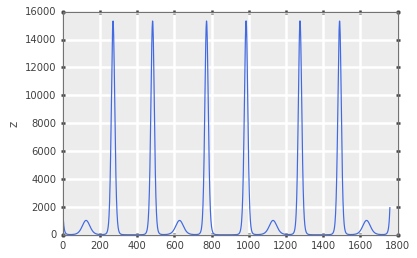

In [46]:
exes = np.arange(0,7*np.pi,0.0125)
series = 2**(10**(np.sin(exes))+10**(np.cos(2*exes)-np.sin(exes)))
plt.plot(series)
plt.ylabel('z')

In [47]:
np.random.seed(1777)
noise3 = np.random.choice([0,1], size=len(series), replace=True)

In [48]:
#make sure that we have approx. equal numbers of 0 and 1
print('#zeros = {}; #ones = {}; #pts = {}'.format(len(noise3)-noise3.sum(), noise3.sum(), len(noise3)))

#zeros = 859; #ones = 901; #pts = 1760


In [49]:
swn3 = []
for idx, n in enumerate(noise3):
    if n:
        swn3.append(series[idx]/2)
    else:
        swn3.append(series[idx]*2)
swn3 = np.array(swn3)

In [50]:
swn1 = series*2.0

In [51]:
swn2 = series/1.5

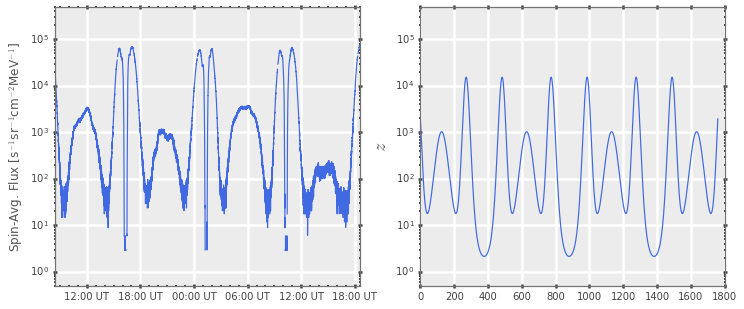

In [52]:
#get RBSP data to show why we choose this series
fns_rbsp = ['rbspa_rel03_ect-mageis-L2_20140119_v4.12.0.cdf','rbspa_rel03_ect-mageis-L2_20140120_v4.12.0.cdf']
rbdata = None
for fn in fns_rbsp:
    fn = '/mnt/projects/RBSP/mageis_l2/'+fn
    dum = dm.fromCDF(fn)
    if rbdata is not None:
        rbdata = np.hstack([rbdata, np.asarray(dum['FESA'][:,6])])
        rbtime = np.hstack([rbtime, np.asarray(dum['Epoch'][:])])
    else:
        rbdata = np.asarray(dum['FESA'][:,6])
        rbtime = np.asarray(dum['Epoch'][:])

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
#ax.plot(swn3)
#ax.plot(swn2)
#ax.plot(swn1)
ax.semilogy(rbtime,rbdata)
ax.set_ylim([0.5,5e5])
ax.set_ylabel('Spin-Avg. Flux [s$^{-1}$sr$^{-1}$cm$^{-2}$MeV$^{-1}$]')
splot.applySmartTimeTicks(ax, rbtime[2800:14100])
ax1 = fig.add_subplot(122)
#ax1.semilogy(swn3)
#ax1.semilogy(swn2)
#ax1.semilogy(swn1)
ax1.semilogy(series)
ax1.set_ylabel('$z$', fontsize=18)
ax1.set_ylim([0.5,5e5])
plt.savefig('placeholder_loglogmodel_seriesz.png')

In [53]:
def MAPE(obs, mod):
    relerr = (mod-obs)/obs
    percerr = relerr*100
    ape = np.abs(percerr)
    return ape.mean()

In [54]:
def mysymMAPE(obs,mod):
    big = np.empty_like(obs)
    small = np.empty_like(obs)
    for idx in range(len(obs)):
        small[idx] = obs[idx] if not(obs[idx]>mod[idx]) else mod[idx]
        big[idx] = obs[idx] if (obs[idx]>mod[idx]) else mod[idx]
    relerr = (big-small)/small
    percerr = relerr*100
    ape = np.abs(percerr)
    return np.median(ape)#ape.mean()

In [55]:
MAPE(swn3, series)

75.596590909090907

In [56]:
MAPE(swn1, series)

50.0

In [57]:
MAPE(swn2, series)

50.0

In [58]:
np.exp(verify.RMSE(np.log(swn1), np.log(series)))

2.0

So if we break MAPE by using log-transformed data, what happens?

In [59]:
MAPE(np.log10(swn1),np.log10(series))

16.971733146861972

In [60]:
MAPE(np.log10(swn2),np.log10(series))

19.281557576345744

In [61]:
MAPE(np.log10(swn3),np.log10(series))

47.09007149631482

Note that this is still asymmetric. 

Now we check what the median symmetric accuracy gives us in these cases...

In [62]:
def MSA(obs,mod):
    q = obs/mod
    abslogq = np.abs(np.log10(q))
    medabslogq = np.median(abslogq)
    msa = 10**(medabslogq)-1
    return msa*100

In [89]:
def sMAPE(obs, mod):
    obs = np.asarray(obs)
    mod = np.asarray(mod)
    spe = 2*np.abs(np.abs(mod-obs)/np.abs(mod+obs))
    smape = spe.mean()
    return 100*smape

In [83]:
MSA(swn1, series)

100.0

In [84]:
MSA(swn2, series)

50.0

In [85]:
MSA(swn3, series)

100.0

In [98]:
print(sMAPE(np.array(series*2),np.array(series)))
print(sMAPE(np.array(series/2),np.array(series)))
print(sMAPE(np.array(swn3),series))

66.6666666667
66.6666666667
66.6666666667


So the median symmetric accuracy returns the same error in all cases, and is demonstrated to be symmetric to over- and under-prediction.

In [91]:
mysymMAPE(swn3, series)

100.0

In [92]:
print('MAPE - untransformed data')
m1 = MAPE(np.array([1e2]), np.array([2.7e3]))
m2 = MAPE(np.array([2.7e3]), np.array([1e2]))
print('obs={}, mod={}, MAPE={}'.format(1e2, 2.7e3, m1))
print('obs={}, mod={}, MAPE={}'.format(2.7e3, 1e2, m2))
print('MAPE asymmetry = {}'.format(m1/m2))
print('\nMAPE - log10 transformed data')
ml1 = MAPE(np.log10(np.array([1e2])), np.log10(np.array([2.7e3])))
ml2 = MAPE(np.log10(np.array([2.7e3])), np.log10(np.array([1e2])))
print(ml1)
print(ml2)
print('MAPE (log) asymmetry = {}'.format(ml1/ml2))
print('\nsMAPE [Makridakis, 1993]')
sm1 = sMAPE(np.array([1e2]), np.array([2.7e3]))
sm2 = sMAPE(np.array([2.7e3]), np.array([1e2]))
print(sm1)
print(sm2)
print('sMAPE asymmetry = {}'.format(sm1/sm2))
print('\nMSA [Morley, 2016]')
msa1 = MSA(np.array([1e2]), np.array([2.7e3]))
msa2 = MSA(np.array([2.7e3]), np.array([1e2]))
print(msa1)
print(msa2)

MAPE - untransformed data
obs=100.0, mod=2700.0, MAPE=2600.0
obs=2700.0, mod=100.0, MAPE=96.2962962963
MAPE asymmetry = 27.0

MAPE - log10 transformed data
71.5681882079
41.7141364932
MAPE (log) asymmetry = 1.71568188208

sMAPE [Makridakis, 1993]
185.714285714
185.714285714
sMAPE asymmetry = 1.0

MSA [Morley, 2016]
2600.0
2600.0


From the results above we see that MAPE is highly asymmetric with respect to over- and under-forecasting (for the same order of difference). Using the logs - which we know is incorrect - is still asymmetric, but also radically underestimates the error. The given values of ~71% and ~42% certainly do not imply to a reader that the difference was a factor of 27. Indeed, they could naively be interpreted as showing an error that is less than a factor of 2.
Though sMAPE is now symmetric when given over- or under-forecasts by the same order, the "percentage error" of ~186% again does not intuitively recover the scale of the error. 
Of the given measures only the MSA indicates that the error is greater than an order of magnitude and does not depend on the sense of the forecast error.

In [25]:
mysymMAPE(np.array([2.7e3]), np.array([1e2]))

2600.0

So as I see in my tests above - this isn't just "interpretable" as a percentage error, it IS the median percentage error if we always set the "observation" to be the larger value and the "model" to be the smaller value. This is essentially an extension of Chen's "matching ratio". As the accuracy ratio is the complement of the relative error (Q = 1-R), we can calculate the percentage error using the relative error implied by the matching ratio. This gives us Perc.Err = 100 * (j<sub>large</sub>-j<sub>small</sub>)/j<sub>small</sub>

This implies that I want to introduce the metric via the log accuracy ratio of Tofallis, and then take the median as a measure of central tendency, then convert to percentage scale.
After various tests, etc. I should then have a section titled "Interpretation and derivation as a percentage error". Where I approach from the matching ratio, convert back to an implied relative error and calculate the percentage error.

So now to justify the median... what is the distribution of APE (using above definition)? I can use arguments and provide citations to, e.g., Coleman and Swanson [2007] and Tofallis [2015]. I should also show an example that's believable for space physics... faked up particle data? faked up B-field? real particle data? If the distribution of relative error is skewed then so is the distribution of accuracy ratio (and vice versa). We symmetrize by taking logs (Tofallis [2015], Morley et al. [2016] and Morley [2016]), and then show the median as a robust measure of central tendency [Morley et al., 2016] as outliers are still present and the log-transform is one of a family of power transforms (an may not be the best one).

In Coleman and Swanson [2007] they refer to the National Research Council as saying a summary measure of error should meet 5 basic criteria. I should couple this with the list of desirable criteria that I have for radiation belt model assessment and use this to justify the use of my accuracy metric when the desirable criteria given match the problem.

In [26]:
def APEdist(obs, mod, symm=False, noabs=False):
    if symm:
        big = np.empty_like(obs).astype(float)
        small = np.empty_like(obs).astype(float)
        for idx in range(len(obs)):
            small[idx] = obs[idx] if not (obs[idx]>mod[idx]) else mod[idx]
            big[idx] = obs[idx] if (obs[idx]>mod[idx]) else mod[idx]
        relerr = (big-small)/small
    else:
        relerr = (mod - obs)/obs
    percerr = relerr*100
    if not noabs:
        return np.abs(percerr)
    else:
        return percerr

Extra discussion required on interpretation...

Transformation back from median symmetric accuracy to magnitude; Is it meaningful? How does it compare to implied magnitude of error from MAPE?

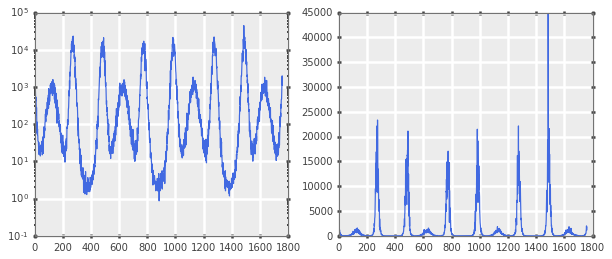

In [27]:
#Multiplicative error model for log flux
y=series
bias, sigma = 0.0, 0.05 #bias defined as signed median log ratio, sigma is std.dev.
bias2, sigma2 = 0.0, 0.3
eta = np.random.normal(size=len(y))
yhat = y*np.exp(sigma*eta+bias)
eta2 = np.random.normal(size=len(y)) #a second noisy series, a la comparing two satellites
yhat2 = y*np.exp(sigma2*eta2+bias2)

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.semilogy(yhat2)
ax2.plot(yhat2)

(0, 4000.0)

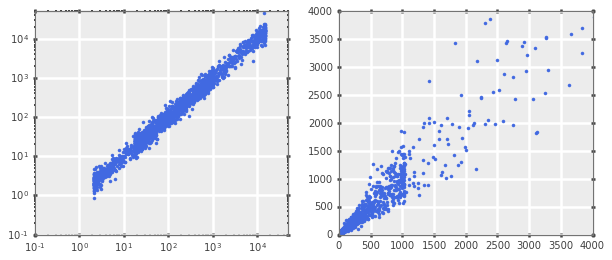

In [28]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.loglog(series,yhat2,'.')
ax1.set_xlim([1e-1,5e4])
ax1.set_ylim([1e-1,5e4])
ax2.plot(series, yhat2, '.')
ax2.set_xlim([0,4e3])
ax2.set_ylim([0,4e3])

24.3271964591
22.7116212176
24.1430385025
22.7116212176


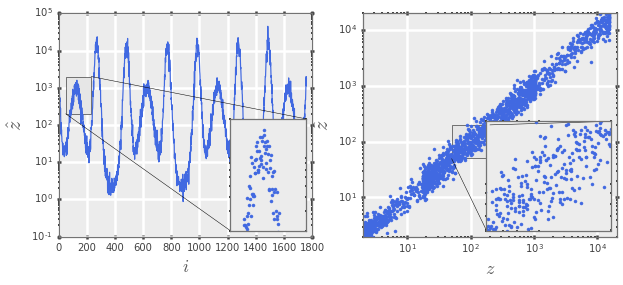

In [29]:
print(MAPE(series, yhat2))
print(MSA(series, yhat2))
print(MAPE(yhat2, series))
print(MSA(yhat2, series))
pedist_asym = APEdist(series, yhat2, symm=False, noabs=True)
log10Q = verify.logAccuracy(series, yhat2, base=10)
mdlogQ = verify.medianLogAccuracy(series, yhat2)
apedist_asym  = APEdist(series, yhat2, symm=False)
apedist_symm = APEdist(series, yhat2, symm=True)
binw, nbins = tb.binHisto(apedist_asym)
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.semilogy(yhat2)
ax.set_ylabel('$\hat{z}$', fontsize=20)
ax.set_xlabel('$i$', fontsize=18)
ax_inset = zoomed_inset_axes(ax, zoom=3, loc=4)
ax_inset.semilogy(yhat2,'.')
ax_inset.set_xlim([50,230])
ax_inset.set_ylim([2e2,2e3])
ax_inset.set_xticks([])
ax_inset.set_yticks([])
mark_inset(ax, ax_inset, loc1=1, loc2=3, fc="0.9", ec="0")

ax0 = fig.add_subplot(122)
ax0.loglog(series,yhat2,'.')
ax0.set_ylabel('$\hat{z}$', fontsize=20)
ax0.set_xlabel('$z$', fontsize=18)
ax0.set_xlim([2e0,2e4])
ax0.set_ylim([2e0,2e4])
ax0_inset = zoomed_inset_axes(ax0, zoom=3.25, loc=4)
ax0_inset.loglog(series, yhat2,'.')
ax0_inset.set_xlim([5e1,2e2])
ax0_inset.set_ylim([5e1,2e2])
ax0_inset.set_xticks([])
ax0_inset.set_yticks([])
mark_inset(ax0, ax0_inset, loc1=3, loc2=1, fc="0.9", ec="0")

plt.savefig('/home/smorley/LaTeX/AccuracyMetrics/series_z.png')

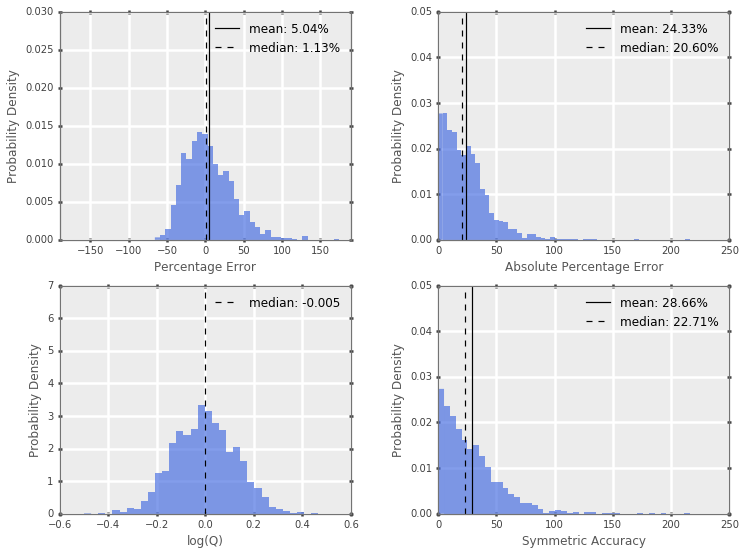

In [30]:
#now plot
fig = plt.figure(figsize=(12,9))
ax0 = fig.add_subplot(223)
binw, nbins = tb.binHisto(log10Q)
pdens_tup = ax0.hist(log10Q, normed=True, bins=int(nbins), alpha=0.65)
ax0.set_ylabel('Probability Density')
ax0.set_xlabel('log(Q)')
plt.vlines(0,0,7, linestyles='dashed',label='median: {:0.3f}'.format(np.median(log10Q)))
plt.legend()
ax = fig.add_subplot(221)
binw, nbins = tb.binHisto(pedist_asym)
pdens_tup = ax.hist(pedist_asym, normed=True, bins=int(nbins), alpha=0.65)
ax.set_ylim([0,0.03])
ax.set_xlim([-190,190])
ax.set_ylabel('Probability Density')
ax.set_xlabel('Percentage Error')
plt.vlines(pedist_asym.mean(),0,ax.get_ylim()[-1], linestyles='solid', label='mean: {:0.2f}%'.format(pedist_asym.mean()))
plt.vlines(np.median(pedist_asym),0,ax.get_ylim()[-1], linestyles='dashed', label='median: {:0.2f}%'.format(np.median(pedist_asym)))
plt.legend()
#add skewed normal
ax1 = fig.add_subplot(222)
binw, nbins = tb.binHisto(apedist_asym)
pdens_tup = ax1.hist(apedist_asym, normed=True, bins=int(nbins), alpha=0.65)
ax1.set_ylim([0,0.05])
ax1.set_ylabel('Probability Density')
ax1.set_xlabel('Absolute Percentage Error')
plt.vlines(apedist_asym.mean(),0,ax1.get_ylim()[-1], linestyles='solid', label='mean: {:0.2f}%'.format(apedist_asym.mean()))
plt.vlines(np.median(apedist_asym),0,ax1.get_ylim()[-1], linestyles='dashed', label='median: {:0.2f}%'.format(np.median(apedist_asym)))
plt.legend()
ax2 = fig.add_subplot(224)
binw, nbins = tb.binHisto(apedist_symm)
pdens_tup = ax2.hist(apedist_symm, normed=True, bins=int(nbins), alpha=0.65)
ax2.set_ylim([0,0.05])
ax2.set_ylabel('Probability Density')
ax2.set_xlabel('Symmetric Accuracy')
plt.vlines(apedist_symm.mean(),0,ax2.get_ylim()[-1], linestyles='solid', label='mean: {:0.2f}%'.format(apedist_symm.mean()))
plt.vlines(np.median(apedist_symm),0,ax2.get_ylim()[-1], linestyles='dashed', label='median: {:0.2f}%'.format(np.median(apedist_symm)))
plt.legend()
plt.subplots_adjust(wspace=0.3)
plt.savefig('/home/smorley/LaTeX/AccuracyMetrics/PE_symmetry.png')

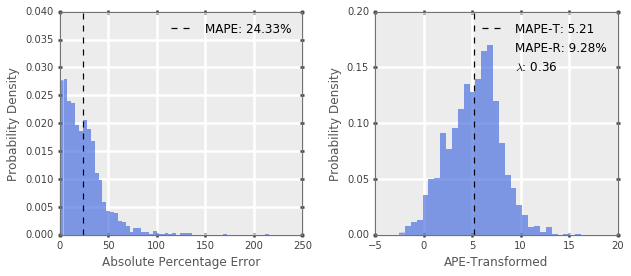

In [31]:
#Quick trial of MAPE-T and MAPE-R
import scipy.stats
ape_t, ape_t_lambda = scipy.stats.boxcox(apedist_asym)
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
binw, nbins = tb.binHisto(apedist_asym)
pdens_tup = ax.hist(apedist_asym, normed=True, bins=int(nbins), alpha=0.65)
ax.set_ylim([0,0.04])
ax.set_ylabel('Probability Density')
ax.set_xlabel('Absolute Percentage Error')
ax.vlines(apedist_asym.mean(),0,ax.get_ylim()[-1], linestyles='dashed', label='MAPE: {:0.2f}%'.format(apedist_asym.mean()))
plt.legend()
ax1 = fig.add_subplot(122)
binw, nbins = tb.binHisto(ape_t)
dum = ax1.hist(ape_t, bins=int(nbins), normed=True, alpha=0.65)
#transform to MAPE-R
mape_r = (ape_t_lambda * (ape_t.mean() + 1))**(1.0/ape_t_lambda)
#build legend
ax1.vlines(ape_t.mean(),0,0.2, linestyles='dashed', label='MAPE-T: {:0.2f}'.format(ape_t.mean()))
ax1.vlines(0,0,0.2, linewidth=0, label='MAPE-R: {:0.2f}%'.format(mape_r))
ax1.vlines(0,0,0.2, linewidth=0, label='$\lambda$: {:0.2f}'.format(ape_t_lambda))
ax1.set_ylabel('Probability Density')
ax1.set_xlabel('APE-Transformed')
plt.legend()

ax1.set_ylim([0,0.2])
plt.subplots_adjust(wspace=0.3)
plt.savefig('/home/smorley/LaTeX/AccuracyMetrics/MAPE-R.png')

## Pick 10% of points in series and add "outliers" (noise from much wider distribution)

In [32]:
bignoise = np.random.choice([0,1], size=len(series), replace=True, p=[0.9,0.1])
#Multiplicative error model for log flux
bias3, sigma3 = 0.0, 8*sigma2
eta3 = np.random.normal(size=len(y[bignoise])) #a second noisy series, a la comparing two satellites

In [33]:
yhat3 = yhat2.copy()
yhat3[bignoise] = y[bignoise]*np.exp(sigma3*eta3+bias3)

24.7120222406
22.7923605961
24.8312465894
22.7923605961


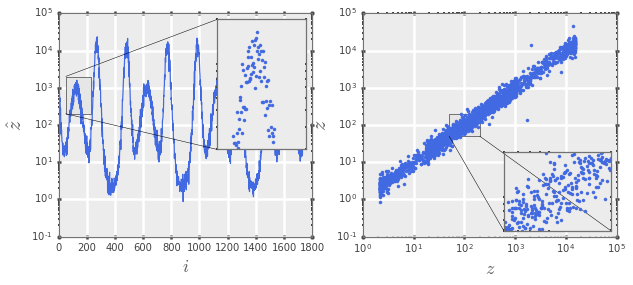

In [34]:
print(MAPE(series, yhat3))
print(MSA(series, yhat3))
print(MAPE(yhat3, series))
print(MSA(yhat3, series))
pedist_asym = APEdist(series, yhat3, symm=False, noabs=True)
log10Q = verify.logAccuracy(series, yhat3, base=10)
mdlogQ = verify.medianLogAccuracy(series, yhat3)
apedist_asym  = APEdist(series, yhat3, symm=False)
apedist_symm = APEdist(series, yhat3, symm=True)
binw, nbins = tb.binHisto(apedist_asym)
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.semilogy(yhat3)
ax.set_ylabel('$\hat{z}$', fontsize=20)
ax.set_xlabel('$i$', fontsize=18)
ax_inset = zoomed_inset_axes(ax, zoom=3.5, loc=1)
ax_inset.semilogy(yhat3,'.')
ax_inset.set_xlim([50,230])
ax_inset.set_ylim([2e2,2e3])
ax_inset.set_xticks([])
ax_inset.set_yticks([])
mark_inset(ax, ax_inset, loc1=2, loc2=3, fc="0.9", ec="0")

ax0 = fig.add_subplot(122)
ax0.loglog(series, yhat3, '.')
ax0.set_ylabel('$\hat{z}$', fontsize=20)
ax0.set_xlabel('$z$', fontsize=18)
ax0_inset = zoomed_inset_axes(ax0, zoom=3.5, loc=4)
ax0_inset.loglog(series, yhat3,'.')
ax0_inset.set_xlim([5e1,2e2])
ax0_inset.set_ylim([5e1,2e2])
ax0_inset.set_xticks([])
ax0_inset.set_yticks([])
mark_inset(ax0, ax0_inset, loc1=3, loc2=4, fc="0.9", ec="0")

plt.savefig('/home/smorley/LaTeX/AccuracyMetrics/series_z3.png')

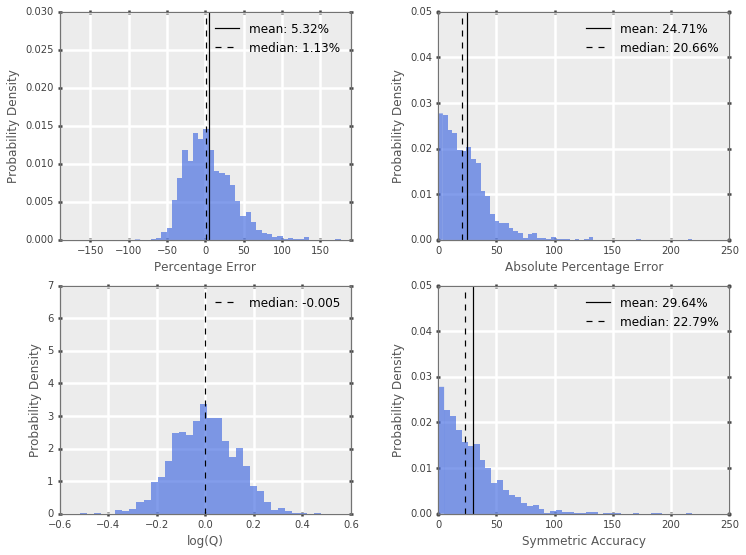

In [35]:
#now plot
fig = plt.figure(figsize=(12,9))
ax0 = fig.add_subplot(223)
binw, nbins = tb.binHisto(log10Q)
pdens_tup = ax0.hist(log10Q, normed=True, bins=int(nbins), alpha=0.65)
ax0.set_ylabel('Probability Density')
ax0.set_xlabel('log(Q)')
ax0.set_xlim([-0.6, 0.6])
plt.vlines(0,0,7, linestyles='dashed',label='median: {:0.3f}'.format(np.median(log10Q)))
plt.legend()
ax = fig.add_subplot(221)
binw, nbins = tb.binHisto(pedist_asym)
pdens_tup = ax.hist(pedist_asym, normed=True, bins=int(nbins), alpha=0.65)
ax.set_ylim([0, 0.03])
ax.set_xlim([-190, 190])
ax.set_ylabel('Probability Density')
ax.set_xlabel('Percentage Error')
plt.vlines(pedist_asym.mean(),0,ax.get_ylim()[-1], linestyles='solid', label='mean: {:0.2f}%'.format(pedist_asym.mean()))
plt.vlines(np.median(pedist_asym),0,ax.get_ylim()[-1], linestyles='dashed', label='median: {:0.2f}%'.format(np.median(pedist_asym)))
plt.legend()
#add skewed normal
ax1 = fig.add_subplot(222)
binw, nbins = tb.binHisto(apedist_asym)
pdens_tup = ax1.hist(apedist_asym, normed=True, bins=int(nbins), alpha=0.65)
ax1.set_ylim([0, 0.05])
ax1.set_xlim([0, 250])
ax1.set_ylabel('Probability Density')
ax1.set_xlabel('Absolute Percentage Error')
plt.vlines(apedist_asym.mean(),0,ax1.get_ylim()[-1], linestyles='solid', label='mean: {:0.2f}%'.format(apedist_asym.mean()))
plt.vlines(np.median(apedist_asym),0,ax1.get_ylim()[-1], linestyles='dashed', label='median: {:0.2f}%'.format(np.median(apedist_asym)))
plt.legend()
ax2 = fig.add_subplot(224)
binw, nbins = tb.binHisto(apedist_symm)
pdens_tup = ax2.hist(apedist_symm, normed=True, bins=int(nbins), alpha=0.65)
ax2.set_ylim([0,0.05])
ax2.set_xlim([0, 250])
ax2.set_ylabel('Probability Density')
ax2.set_xlabel('Symmetric Accuracy')
plt.vlines(apedist_symm.mean(),0,ax2.get_ylim()[-1], linestyles='solid', label='mean: {:0.2f}%'.format(apedist_symm.mean()))
plt.vlines(np.median(apedist_symm),0,ax2.get_ylim()[-1], linestyles='dashed', label='median: {:0.2f}%'.format(np.median(apedist_symm)))
plt.legend()
plt.subplots_adjust(wspace=0.3)
plt.savefig('/home/smorley/LaTeX/AccuracyMetrics/PE_symmetry3.png')

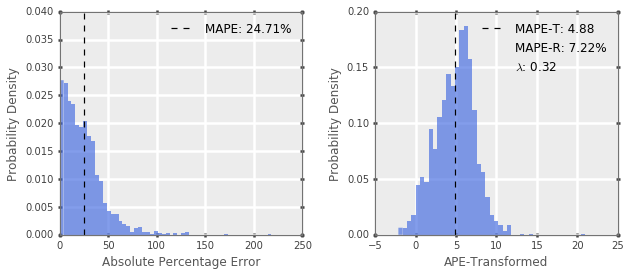

In [36]:
ape_t, ape_t_lambda = scipy.stats.boxcox(apedist_asym)
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
binw, nbins = tb.binHisto(apedist_asym)
pdens_tup = ax.hist(apedist_asym, normed=True, bins=int(nbins), alpha=0.65)
ax.set_ylim([0,0.04])
ax.set_xlim([0,250])
ax.set_ylabel('Probability Density')
ax.set_xlabel('Absolute Percentage Error')
ax.vlines(apedist_asym.mean(),0,ax.get_ylim()[-1], linestyles='dashed', label='MAPE: {:0.2f}%'.format(apedist_asym.mean()))
plt.legend()
ax1 = fig.add_subplot(122)
binw, nbins = tb.binHisto(ape_t)
dum = ax1.hist(ape_t, bins=int(nbins), normed=True, alpha=0.65)
#transform to MAPE-R
mape_r = (ape_t_lambda * (ape_t.mean() + 1))**(1.0/ape_t_lambda)
#build legend
ax1.vlines(ape_t.mean(),0,0.2, linestyles='dashed', label='MAPE-T: {:0.2f}'.format(ape_t.mean()))
ax1.vlines(0,0,0.2, linewidth=0, label='MAPE-R: {:0.2f}%'.format(mape_r))
ax1.vlines(0,0,0.2, linewidth=0, label='$\lambda$: {:0.2f}'.format(ape_t_lambda))
ax1.set_ylabel('Probability Density')
ax1.set_xlabel('APE-Transformed')
plt.legend()

ax1.set_ylim([0,0.2])
plt.subplots_adjust(wspace=0.3)
plt.savefig('/home/smorley/LaTeX/AccuracyMetrics/MAPE-R_z3.png')


## Testing the use of log(Q) to estimate sigma
RMSE is sample estimate of sigma. We can approximate this robustly using Md(log(Q)).

In [37]:
est_sigma_MSA = 10**(np.median(np.abs(np.log10(series/yhat2))))-1 #- np.median(np.log(yhat2/series))
est_sigma_rmse = np.sqrt(((np.log(series)-np.log(yhat2))**2).mean()) #- np.median(np.log(yhat2/series))

print(sigma2, est_sigma_MSA, est_sigma_rmse)

(0.3, 0.22711621217554767, 0.29434232509910552)


In [38]:
print(np.median(np.log10(yhat2/series)))

0.00487606180859


In [39]:
msaarr, maearr, rmsel = [], [], []
msaarr3, maearr3, rmsel3 = [], [], [] #with extra noise
snlogq, snlogq3 = [], []
sigarr = np.arange(0.002,6.0,0.005)
for sigma2 in sigarr:
    eta2 = np.random.normal(size=len(y))
    yhat2 = y*np.exp(sigma2*eta2)
    msaarr.append(MSA(series, yhat2)/100.0)
    maearr.append(np.median(np.abs(np.log(series/yhat2))))
    rmsel.append(np.sqrt(((np.log(series)-np.log(yhat2))**2).mean()))
    yhat3 = yhat2.copy()
    yhat3[bignoise] = y[bignoise]*np.exp(8*sigma2*eta2[bignoise])
    msaarr3.append(MSA(series, yhat3)/100.0)
    maearr3.append(np.median(np.abs(np.log(series/yhat3))))
    rmsel3.append(np.sqrt(((np.log(series)-np.log(yhat3))**2).mean()))
    #also test Sn as estimator of sigma
    snlogq.append(verify.Sn(np.log(series/yhat2)))
    snlogq3.append(verify.Sn(np.log(series/yhat3)))

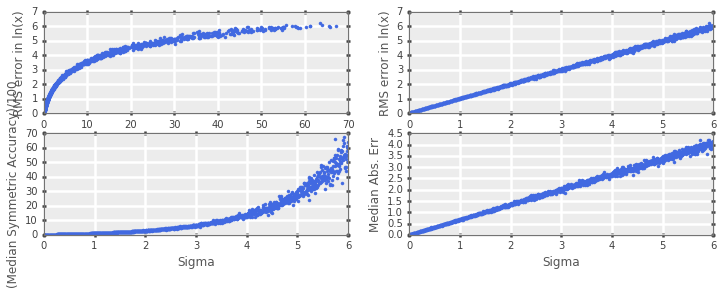

In [40]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(221)
ax1.plot(msaarr, rmsel, '.')
ax1.set_xlabel('(Median Symmetric Accuracy)/100')
ax1.set_ylabel('RMS error in ln(x)')
ax2 = fig.add_subplot(222)
ax2.plot(sigarr, np.array(rmsel), '.')
ax2.set_xlabel('Sigma')
ax2.set_ylabel('RMS error in ln(x)')
ax3 = fig.add_subplot(223)
ax3.plot(sigarr, np.array(msaarr), '.')
ax3.set_xlabel('Sigma')
ax3.set_ylabel('(Median Symmetric Accuracy)/100')
ax4 = fig.add_subplot(224)
ax4.plot(sigarr, np.array(maearr), '.')
ax4.set_xlabel('Sigma')
ax4.set_ylabel('Median Abs. Err')
fig.subplots_adjust()

In [41]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sigarr,np.array(msaarr)*5.1)
print(slope, intercept, r_value, p_value, std_err)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sigarr,rmsel)
print(slope, intercept, r_value, p_value, std_err)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sigarr,np.array(maearr)*1.48)
print(slope, intercept, r_value, p_value, std_err)

(38.593720218746007, -49.799106884394632, 0.88382575300679234, 0.0, 0.59019684166706177)
(0.99697661202474008, 0.0044787971317918895, 0.99942002916579098, 0.0, 0.00098143967113361913)
(0.99707001118779592, 0.0019378422803240092, 0.99843173347107661, 0.0, 0.0016152266247460424)


Drawing on the fact that the median absolute deviation can be used as a robust estimator of the standard deviation, we analogously use the median absolute error as an estimator of the rmse (which is seen to be the standard deviation of the error distribution). So the scaling should be, and appears to be, the same: ~1.48.

An alternative thought... if I want to estimate, robustly, the spread of the errors, then maybe I want Sn of log(Q)?
The scaling from Sn to standard deviation (in the case of a gaussian) is 

In [42]:
np.median(scipy.stats.halfnorm.rvs(scale=1, size=10000))

0.68280605572824726

(0.99697661202474008, 0.0044787971317918895, 0.99942002916579098, 0.0, 0.00098143967113361913)
(1.0316721404540794, 0.0033721348590631806, 0.99734245774593677, 0.0, 0.0021773855794278863)
(0.99882162066691038, 0.0019412465978416726, 0.99843173347107816, 0.0, 0.0016180641850319546)
(1.0000649199897691, 0.0017092930239055448, 0.99842792766816857, 0.0, 0.0016220475125008924)
(0.99751436580063824, 0.0035267571861083979, 0.99906260229423549, 0.0, 0.0012487433484752771)
(0.99915894428194962, 0.0033484310559832586, 0.99905478236420342, 0.0, 0.0012560158625838798)


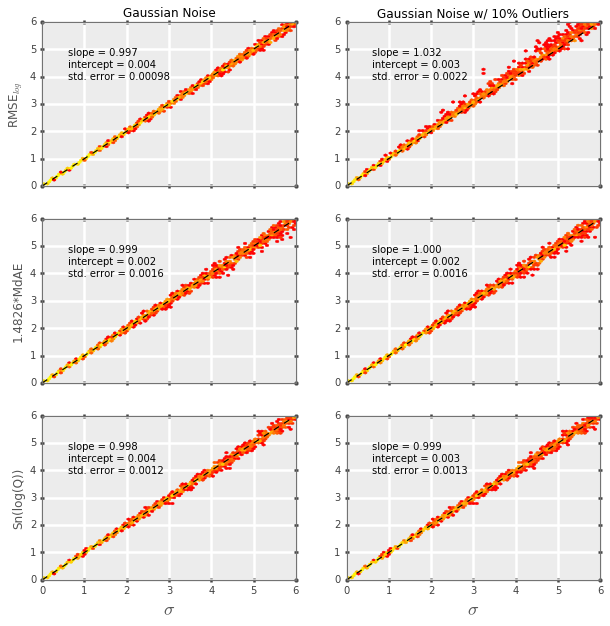

In [43]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

axlist = [ax1, ax2, ax3, ax4, ax5, ax6]
serlist = [rmsel, rmsel3, np.asarray(maearr)*1.4826, np.asarray(maearr3)*1.4826, snlogq, snlogq3]
for cax, ser in zip(axlist, serlist):
    cax.hexbin(sigarr, ser, gridsize=75, cmap='autumn', bins='log', mincnt=1)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sigarr,ser)
    print(slope, intercept, r_value, p_value, std_err)
    cax.text(0.1,0.65, 
             'slope = {:0.3f}\nintercept = {:0.3f}\nstd. error = {:0.2g}'.format(slope, intercept, std_err), 
             transform=cax.transAxes)
    cax.set_xlim([0,6])
    cax.set_ylim([0,6])
    cax.plot([0,6],[0,6],'k--')
ax1.set_title('Gaussian Noise')
ax1.set_ylabel('RMSE$_{log}$')
ax2.set_title('Gaussian Noise w/ 10% Outliers')
ax3.set_ylabel('1.4826*MdAE')
ax5.set_ylabel('Sn(log(Q))')
ax5.set_xlabel('$\sigma$', fontsize=18)
ax6.set_xlabel('$\sigma$', fontsize=18)

for cax in [ax1, ax2, ax3, ax4]:
    cax.set_xticklabels([])
    
plt.savefig('/home/smorley/LaTeX/AccuracyMetrics/estimating_sigma.png')

In [44]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sigarr,snlogq)
print(slope, intercept, r_value, p_value, std_err)

(0.99751436580063824, 0.0035267571861083979, 0.99906260229423549, 0.0, 0.0012487433484752771)


## So Sn of log(Q) appears to be a really accurate, robust estimator of sigma (and/or RMSE log Q). The drawback is that Sn is computationally expensive.

To demonstrate the robustness I should add in some outliers. I should randomly pick ~10% of the points in y-hat and replace them with random variates drawn from a Gaussian with a much larger sigma. Then re-run the calculations of RMSE, MdAE and Sn, and plot scatter plots again.